In [1]:
import numpy as np
from scipy.signal import find_peaks
from nozzle import Spectral, Params, Nozzle
import copy

# Define $v$ on integer grid, but evaluate on half-grid
$$ \omega^2v + 2iv_0\omega v' + (1-v_0^2) v'' = 0, v(\pm 1) = 0 $$
$v$ is defined on the integer-grid and the equation is evaluated on half-grid.

$$ \omega^2v_{i+1/2} + 2iv_0\omega (dv/dx)_{i+1/2} + (1-v_0^2) (d^2v/dx^2)_{i+1/2} = 0, v(\pm 1) = 0 $$

<AxesSubplot:xlabel='x', ylabel='v'>

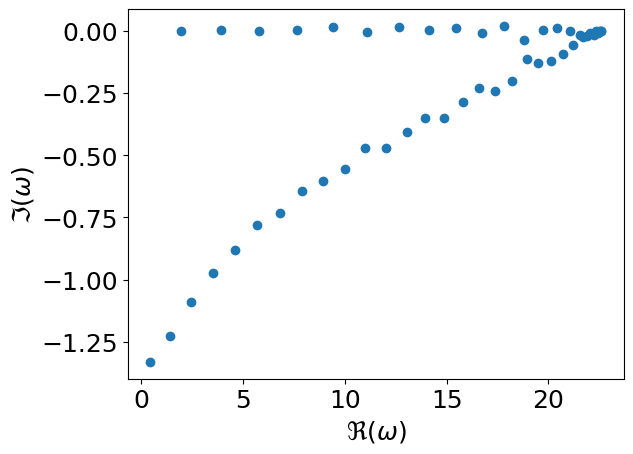

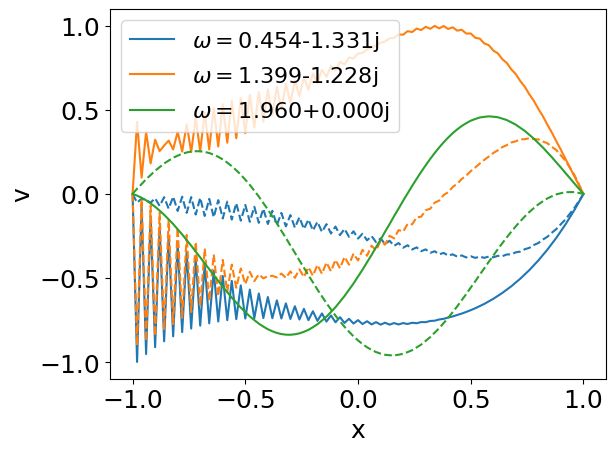

In [2]:
v0 = 1.5
N = 101
x = np.linspace(-1,1, N)
h = x[1] - x[0] # the space between nodes are the same for integer and half grid
# the matrix to compute v_{i+1/2} from v_{i}
Mv = np.zeros((N-2,N-2))
for i in range(Mv.shape[0]):
    for j in range(Mv.shape[1]):
        if i == j:
            Mv[i,j] = 0.5 
        elif j == i + 1:
            Mv[i,j] = 0.5

D1 = np.zeros((N-2,N-2))
for i in range(D1.shape[0]):
    for j in range(D1.shape[1]):
        if i == j:
            D1[i,j] = -1
        elif j == i + 1:
            D1[i,j] = 1
D1 /= h

D2 = np.zeros((N-2,N-2))
for i in range(D2.shape[0]):
    if i == 0:
        D2[i,:3] = [-1,-1,1]
    elif i >= D2.shape[0]-2:
        D2[i,-3:] = [1,-1,-1]
    else:
        D2[i,i-1:i+3] = [1,-1,-1,1]
D2 /= 2*h**2


params = Params(Mm=v0, constant_v=True)
nozzle = Nozzle(params, x)
nozzle.solve((1-v0**2)*D2, 2j*v0*D1, Mv)
nozzle.sort_solutions(real_range=[0.1,100])
nozzle.plot_eigenvalues()
nozzle.plot_eigenfunctions()

# Define and evaluate $v$ on the same grid, and remove large $k$ modes.

/tmp/ipykernel_11138/2179322114.py:29: RuntimeWarning: Mean of empty slice.
  wave_length = np.diff(x[np.isclose(v.real,0)][::2]).mean()
/home/huntfeng/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot:xlabel='x', ylabel='v'>

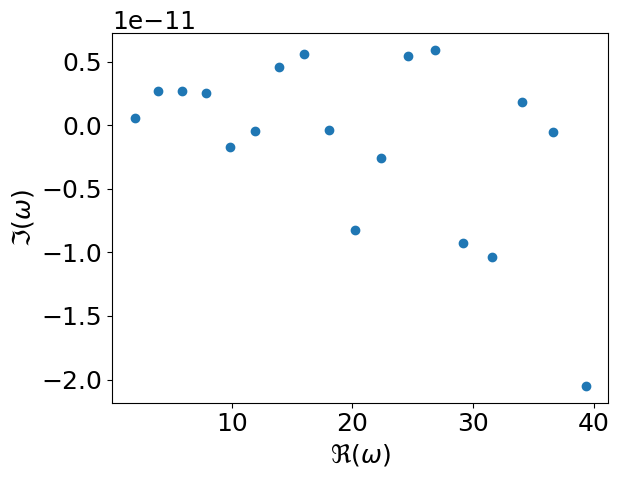

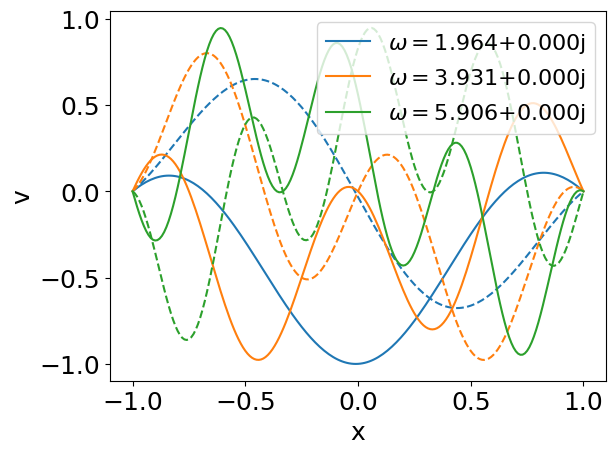

In [3]:
N = 201
v0 = 1.5
spectral = Spectral(N, "symmetric", "FD")
params = Params(Mm=v0, constant_v=True)
nozzle = Nozzle(params, spectral.x)

x = spectral.x
D1 = spectral.D1[1:-1,1:-1]
D2 = spectral.D2[1:-1,1:-1]
I = np.eye(N-2)

nozzle.solve((1-v0**2)*D2, 2j*v0*D1, I)
nozzle.sort_solutions(real_range=[0.1,100])

# filter solutions
k_max = 2/h*np.arcsin(1/v0)
V_ = []
omega_ = []
for i in range(nozzle.omega.size):
    v = nozzle.V[:,i]
    w = nozzle.omega[i]

    # calculate k by counting peaks
    pos = find_peaks(v.real)[0]
    wave_length = np.diff(x[pos]).mean()
    k_peak = 2*np.pi/wave_length

    # calculate k by counting zeros
    wave_length = np.diff(x[np.isclose(v.real,0)][::2]).mean()
    k_zero = 2*np.pi/wave_length
    k = max(k_peak, k_zero)
    if k < k_max:
        V_.append(v)
        omega_.append(w)
nozzle.V = np.column_stack(V_)  
nozzle.omega = np.array(omega_)


nozzle.plot_eigenvalues()
nozzle.plot_eigenfunctions()